# Урок 5. Случайный лес

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

Повторим реализацию построения дерева решений из предыдущего урока

In [3]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [5]:
random.seed(42)

def get_bootstrap(data, labels, N):
       
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        # TODO: random.choice()
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

    return bootstrap

random.seed(42)
def get_bootstrap(data, labels, N):
       
    n_samples = data.shape[0]
    bootstrap = []
    test_samples = []
    for i in range(N):
        sample_index = random.choices(np.arange(n_samples), k=n_samples)
        
        b_data = np.array(data[sample_index])
        b_labels =  np.array(labels[sample_index])
        bootstrap.append((b_data, b_labels))

    return bootstrap

In [6]:
def get_subsample(len_sample):
    
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for i in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf=1):
    
    #  обозначим минимальное количество объектов в узле
#     min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels, min_leaf=1)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [12]:
def random_forest(data, labels, n_trees):
    
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [13]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

### Предсказание голосованием деревьев

In [15]:
def tree_vote(forest, data):
    
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
        
    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее.

In [16]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Тест самописного случайного леса

In [18]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 490 ms


In [19]:
train_answs = tree_vote(my_forest_1, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 1 деревьев на train: 93.143


In [20]:
test_answs = tree_vote(my_forest_1, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 1 деревьев на test: 93.333


In [21]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

Wall time: 1.11 s


In [22]:
train_answs = tree_vote(my_forest_3, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 97.429


In [23]:
test_answs = tree_vote(my_forest_3, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 96.000


In [24]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 3.92 s


In [25]:
train_answs = tree_vote(my_forest_10, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 10 деревьев на train: 99.143


In [26]:
test_answs = tree_vote(my_forest_10, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 10 деревьев на test: 96.667


In [27]:
%%time
n_trees = 30
my_forest_30 = random_forest(train_data, train_labels, n_trees)

Wall time: 11.7 s


In [28]:
train_answs = tree_vote(my_forest_30, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 30 деревьев на train: 99.714


In [29]:
test_answs = tree_vote(my_forest_30, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 30 деревьев на test: 95.333


In [30]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

Wall time: 20.2 s


In [31]:
train_answs = tree_vote(my_forest_50, train_data)

train_acc = accuracy_metric(train_labels, train_answs)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 50 деревьев на train: 100.000


In [32]:
test_answs = tree_vote(my_forest_50, test_data)

test_acc = accuracy_metric(test_labels, test_answs)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 50 деревьев на test: 96.000


### Домашнее задание


1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать  
 их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).  
   Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем (*).  


In [33]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [34]:
classification_data_hw, classification_labels_hw = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [35]:
train, test, train_y, test_y = model_selection.train_test_split(classification_data_hw,
                                                                classification_labels_hw, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [36]:
n_trees = 1
forest_1tree = random_forest(train, train_y, n_trees)

In [37]:
train_pred = tree_vote(forest_1tree, train)
train_acc = accuracy_metric(train_y, train_pred)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 1 деревьев на train: 91.429


In [38]:
test_pred = tree_vote(forest_1tree, test)

test_acc = accuracy_metric(test_y, test_pred)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 1 деревьев на test: 86.667


Text(0.5, 1.0, 'Test 1 trees')

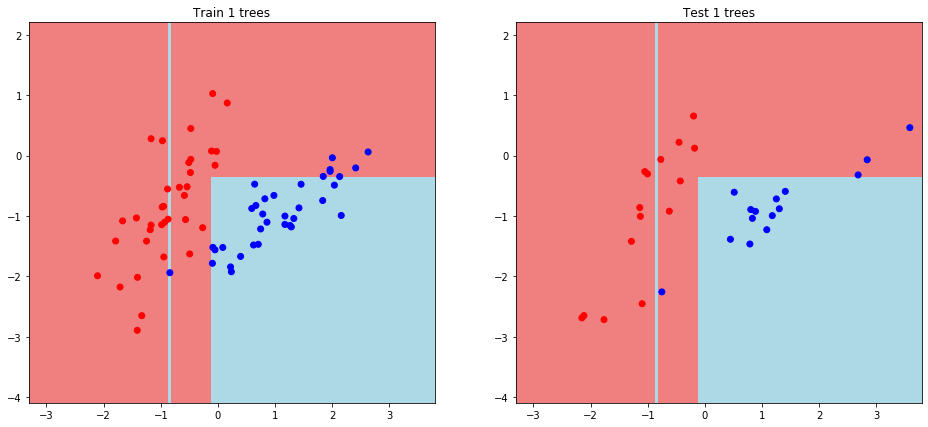

In [39]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train)
mesh_predictions = np.array(tree_vote(forest_1tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train[:, 0], train[:, 1], c = train_y, cmap = colors)
plt.title(f'Train {n_trees} trees')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test[:, 0], test[:, 1], c = test_y, cmap = colors)
plt.title(f'Test {n_trees} trees')

In [40]:
n_trees = 3
forest_3tree = random_forest(train, train_y, n_trees)

In [41]:
train_pred = tree_vote(forest_3tree, train)
train_acc = accuracy_metric(train_y, train_pred)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 3 деревьев на train: 100.000


In [42]:
test_pred = tree_vote(forest_3tree, test)

test_acc = accuracy_metric(test_y, test_pred)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 3 деревьев на test: 96.667


Text(0.5, 1.0, 'Test 3 trees')

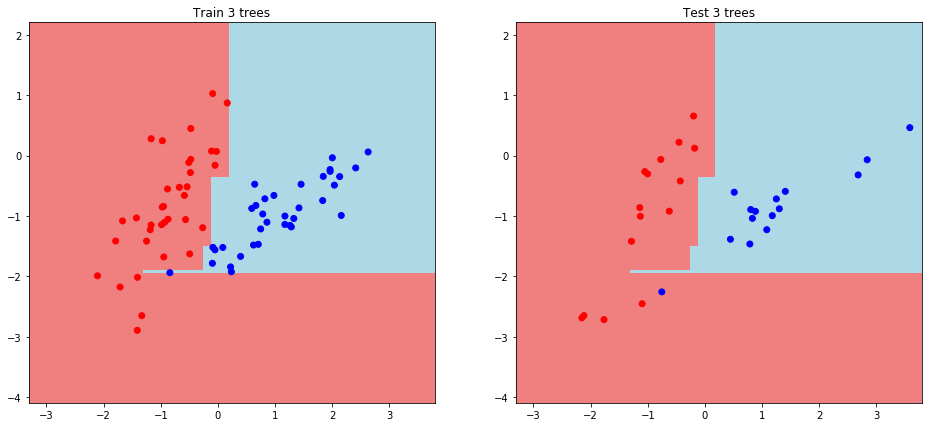

In [43]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train)
mesh_predictions = np.array(tree_vote(forest_3tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train[:, 0], train[:, 1], c = train_y, cmap = colors)
plt.title(f'Train {n_trees} trees')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test[:, 0], test[:, 1], c = test_y, cmap = colors)
plt.title(f'Test {n_trees} trees')

In [44]:
n_trees = 10
forest_1tree = random_forest(train, train_y, n_trees)

In [45]:
train_pred = tree_vote(forest_1tree, train)
train_acc = accuracy_metric(train_y, train_pred)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 10 деревьев на train: 100.000


In [46]:
test_pred = tree_vote(forest_1tree, test)

test_acc = accuracy_metric(test_y, test_pred)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 10 деревьев на test: 93.333


Text(0.5, 1.0, 'Test 10 trees')

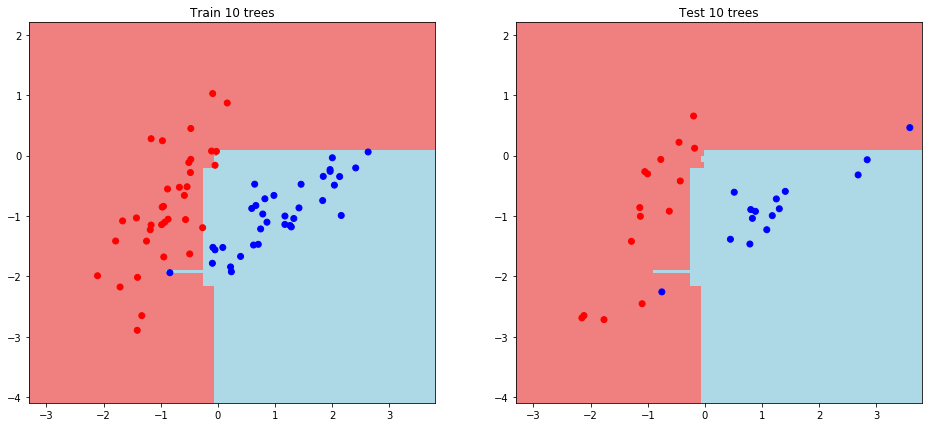

In [47]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train)
mesh_predictions = np.array(tree_vote(forest_1tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train[:, 0], train[:, 1], c = train_y, cmap = colors)
plt.title(f'Train {n_trees} trees')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test[:, 0], test[:, 1], c = test_y, cmap = colors)
plt.title(f'Test {n_trees} trees')

In [48]:
n_trees = 50
forest_50tree = random_forest(train, train_y, n_trees)

In [49]:
train_pred = tree_vote(forest_50tree, train)
train_acc = accuracy_metric(train_y, train_pred)
print(f'Точность случайного леса из {n_trees} деревьев на train: {train_acc:.3f}')

Точность случайного леса из 50 деревьев на train: 100.000


In [50]:
test_pred = tree_vote(forest_50tree, test)

test_acc = accuracy_metric(test_y, test_pred)
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_acc:.3f}')

Точность случайного леса из 50 деревьев на test: 93.333


Text(0.5, 1.0, 'Test 50 trees')

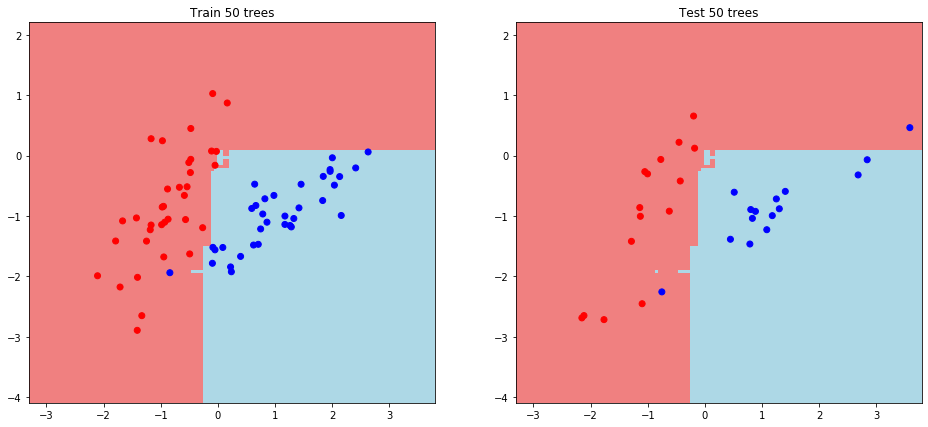

In [51]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train)
mesh_predictions = np.array(tree_vote(forest_50tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train[:, 0], train[:, 1], c = train_y, cmap = colors)
plt.title(f'Train {n_trees} trees')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test[:, 0], test[:, 1], c = test_y, cmap = colors)
plt.title(f'Test {n_trees} trees')

2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.  


In [52]:
# new bootstrap with  # TODO: random.choice()
def get_bootstrap_oob(data, labels, N):
       
    n_samples = data.shape[0]
    bootstrap = []
    test_labels = []
    test_data = []
    for i in range(N):
        standard_indexes = np.arange(n_samples)
        sample_index = random.choices(standard_indexes, k=n_samples)
        test_ind = [i for i in standard_indexes if i not in sample_index]
        t_data = np.array(data[test_ind])
        t_labels = np.array(labels[test_ind])
        b_data = np.array(data[sample_index])
        b_labels =  np.array(labels[sample_index])
        bootstrap.append((b_data, b_labels))
        test_labels.append(t_labels)
        test_data.append(t_data)
            

    return bootstrap, test_data, test_labels

In [53]:
def random_forest(data, labels, n_trees):
    
    forest = []
    bootstrap, test_data, test_labels = get_bootstrap_oob(data, labels, n_trees)
       
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, test_data, test_labels

In [54]:
classification_data_oob, classification_labels_oob = datasets.make_classification(n_samples=5000,
                                                      n_features = 3, n_informative = 3, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [55]:
n_trees = 5
my_forest_oob_10trees, test_data, test_labels = random_forest(classification_data_oob, classification_labels_oob, n_trees)

In [56]:
data_pred = tree_vote(my_forest_oob_10trees, classification_data_oob)
data_acc = accuracy_metric(classification_labels_oob, data_pred)
print(f'Точность случайного леса из {n_trees} деревьев на bootstrap data: {train_acc:.3f}')

Точность случайного леса из 5 деревьев на bootstrap data: 100.000


In [57]:
test_pred = []
for data in test_data:
    y = tree_vote(my_forest_oob_10trees, data)
    test_pred.append(y)
for n in range(len(test_labels)):
    test_acc = accuracy_metric(test_labels[n], test_pred[n])
    print(f'Точность случайного леса из {n_trees} деревьев на out-of-bag samples: {test_acc:.3f}')

Точность случайного леса из 5 деревьев на out-of-bag samples: 99.514
Точность случайного леса из 5 деревьев на out-of-bag samples: 99.179
Точность случайного леса из 5 деревьев на out-of-bag samples: 99.291
Точность случайного леса из 5 деревьев на out-of-bag samples: 99.402
Точность случайного леса из 5 деревьев на out-of-bag samples: 99.304


In [58]:
#classification_data_hw, classification_labels_hw

3. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy (*).  

In [59]:
def calc_entropy(labels):   
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity